In [52]:
import numpy as np 
import cv2
from skimage import io
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, image_folder_path, transform=None):
        self.image_folder_path = image_folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        print(self.image_files)
        if not self.image_files:
            raise ValueError("No images found in the directory!")
        
        
        self.labels = [0] * len(self.image_files)
        print(f"Number of images: {len(self.image_files)}")

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder_path, self.image_files[idx])
        
        image = Image.open(img_name).convert("RGB")
        

        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = CustomImageDataset(image_folder_path=r'C:\Users\ujjwal\pytorch_env\test_dataset', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
for images, labels in data_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

['dark_current_B_25.png', 'dark_current_G_25.png', 'dark_current_NIR_25.png', 'dark_current_R_25.png', 'degraded_B_25.png', 'degraded_G_25.png', 'degraded_NIR_25.png', 'degraded_R_25.png', 'flat_field_B_25.png', 'flat_field_G_25.png', 'flat_field_NIR_25.png', 'flat_field_R_25.png', 'original_B_25.png', 'original_G_25.png', 'original_NIR_25.png', 'original_R_25.png']
Number of images: 16
Batch of images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


In [41]:
def radiometric_correction(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    corrected_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return corrected_image

def geometric_correction(image, src_points, dst_points):
    matrix = cv2.getAffineTransform(np.float32(src_points), np.float32(dst_points))
    corrected_image = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
    return corrected_image

def spectral_correction(image):
    result = image.astype(np.float32)
    for channel in range(result.shape[2]):
        channel_mean = np.mean(result[:, :, channel])
        result[:, :, channel] = np.clip(result[:, :, channel] / channel_mean * 128, 0, 255)
    return result.astype(np.uint8)

dataset = CustomImageDataset(image_folder_path=r'C:\Users\ujjwal\pytorch_env\test_dataset', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
src_points = [[50, 50], [200, 50], [50, 200]]
dst_points = [[60, 60], [210, 50], [50, 220]]
corrected_dataset = []
for images, labels in data_loader:
    corrected_batch = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * 255).astype('uint8')
        radiometric_corrected = radiometric_correction(img_np)
        geometric_corrected = geometric_correction(radiometric_corrected, src_points, dst_points)
        spectral_corrected = spectral_correction(geometric_corrected)
        corrected_img_tensor = torch.tensor(spectral_corrected).permute(2, 0, 1) / 255.0
        corrected_batch.append(corrected_img_tensor)
    corrected_dataset.append(torch.stack(corrected_batch))
final_corrected_dataset = torch.cat(corrected_dataset)
print(f"Final corrected dataset shape: {final_corrected_dataset.shape}")


['dark_current_B_25.png', 'dark_current_G_25.png', 'dark_current_NIR_25.png', 'dark_current_R_25.png', 'degraded_B_25.png', 'degraded_G_25.png', 'degraded_NIR_25.png', 'degraded_R_25.png', 'flat_field_B_25.png', 'flat_field_G_25.png', 'flat_field_NIR_25.png', 'flat_field_R_25.png', 'original_B_25.png', 'original_G_25.png', 'original_NIR_25.png', 'original_R_25.png']
Number of images: 16
Final corrected dataset shape: torch.Size([16, 3, 224, 224])


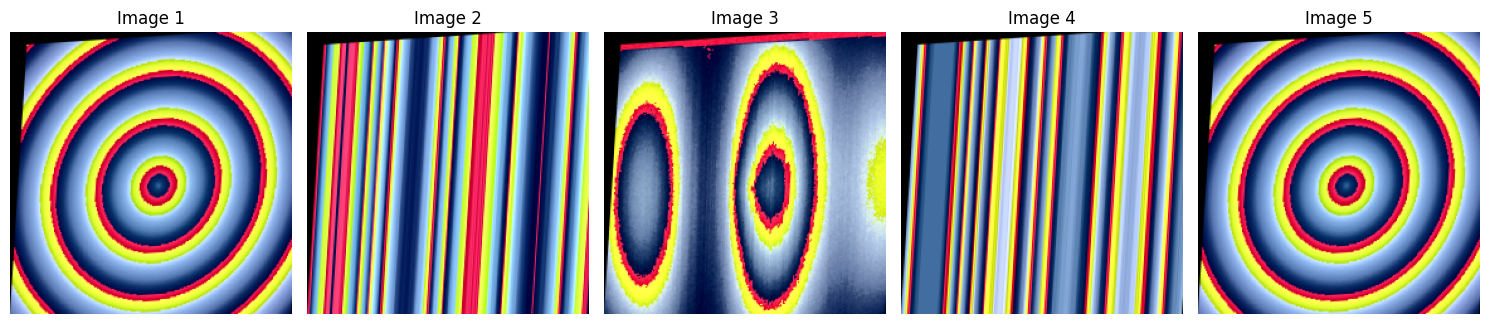

In [43]:
def visualize_images(corrected_dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img_tensor = corrected_dataset[i]
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * 255).astype('uint8')
        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")
    plt.tight_layout()
    plt.show()
visualize_images(corrected_batch)
        

In [44]:
train_size = 10
test_size = len(dataset) - train_size
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [45]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


In [46]:
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Training Batch {batch_idx}: {images.shape}, {labels.shape}")

Training Batch 0: torch.Size([4, 3, 224, 224]), torch.Size([4])
Training Batch 1: torch.Size([4, 3, 224, 224]), torch.Size([4])
Training Batch 2: torch.Size([2, 3, 224, 224]), torch.Size([2])


In [47]:
for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"Testing Batch {batch_idx}: {images.shape}, {labels.shape}")

Testing Batch 0: torch.Size([2, 3, 224, 224]), torch.Size([2])
Testing Batch 1: torch.Size([2, 3, 224, 224]), torch.Size([2])
Testing Batch 2: torch.Size([2, 3, 224, 224]), torch.Size([2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..-1.6301525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..-1.6301525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..-1.6301525].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..-1.6301525].


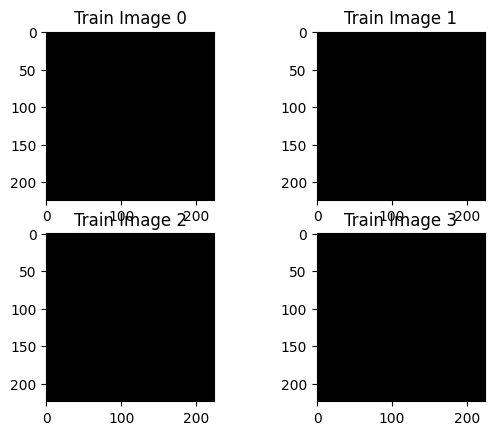

In [48]:
for i in range(4):
    img, label = train_dataset[i]
    plt.subplot(2, 2, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Train Image {i}")
plt.show()

In [ ]:
train_size = 10
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [50]:
def process_batch(batch):
    processed_batch = []
    for img in batch:
        img_np = img.permute(1, 2, 0).numpy() * 255.0
        img_np = img_np.astype('uint8')
        radiometric_corrected = radiometric_correction(img_np)
        geometric_corrected = geometric_correction(radiometric_corrected, src_points, dst_points)
        spectral_corrected = spectral_correction(geometric_corrected)
        corrected_tensor = torch.tensor(spectral_corrected).permute(2, 0, 1) / 255.0
        processed_batch.append(corrected_tensor)
    return torch.stack(processed_batch)

In [ ]:
def calculate_metrics(original, corrected):
    mse = np.mean((original - corrected) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    ssim_score = ssim(original, corrected, channel_axis=-1, data_range=255, win_size=7)
    return mse, psnr, ssim_score


for batch_idx, (images, _) in enumerate(test_loader):
    for i in range(len(images)):
        original = images[i].permute(1, 2, 0).numpy() * 255.0
        corrected = processed_images[i].permute(1, 2, 0).numpy() * 255.0
        print(f"Original shape: {original.shape}, Corrected shape: {corrected.shape}")  
        mse, psnr, ssim_score = calculate_metrics(original, corrected)
        print(f"Test Image {batch_idx * len(processed_images) + i}: MSE={mse}, PSNR={psnr}, SSIM={ssim_score}")

Original shape: (224, 224, 3), Corrected shape: (224, 224, 3)
Test Image 0: MSE=70504.0390625, PSNR=-0.3513364872739606, SSIM=0.0058861845172941685
Original shape: (224, 224, 3), Corrected shape: (224, 224, 3)
Test Image 1: MSE=70504.0390625, PSNR=-0.3513364872739606, SSIM=0.0058861845172941685
Original shape: (224, 224, 3), Corrected shape: (224, 224, 3)
Test Image 2: MSE=98437.890625, PSNR=-1.8008195449777782, SSIM=-0.011208385229110718
Original shape: (224, 224, 3), Corrected shape: (224, 224, 3)
Test Image 3: MSE=99821.078125, PSNR=-1.861418778031747, SSIM=-0.013001601211726665
Original shape: (224, 224, 3), Corrected shape: (224, 224, 3)
Test Image 4: MSE=91194.3046875, PSNR=-1.468873555948468, SSIM=-0.008718305267393589
Original shape: (224, 224, 3), Corrected shape: (224, 224, 3)
Test Image 5: MSE=93893.1953125, PSNR=-1.5955372066076567, SSIM=-0.013882394880056381
